# Import dependencies

In [1]:
import copy
import time
import gc

In [2]:
import xml.etree.ElementTree as ET

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch import cuda

In [6]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, BertConfig

In [7]:
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle

In [8]:
from semeval_reader import SemevalReader
from utils import get_target_list_for_polarity, get_polarity_from_target_list, print_split_by_labels

In [9]:
from ModelDataset import ModelDataset

In [10]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [11]:
torch.cuda.empty_cache()

with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

0

# Load Data

In [12]:
semeval_reader = SemevalReader('semeval16_restaurants_train.xml')

In [13]:
reviews = semeval_reader.read_reviews()

In [14]:
print(f"No. reviews: {len(reviews)}")
print(f"No. sentences: {sum(map(lambda x: len(x.sentences), reviews))}")

No. reviews: 350
No. sentences: 2000


In [15]:
absolute_polarity_sentences = semeval_reader.get_absolute_polarity_sentences()

In [16]:
print(f"No. sentences that have only one polarity: {len(absolute_polarity_sentences)}")

No. sentences that have only one polarity: 1565


In [17]:
absolute_polarity_df = pd.DataFrame(map(lambda x: (x.text, x.opinions[0].polarity), absolute_polarity_sentences))

In [18]:
absolute_polarity_df.rename(columns={0: 'text'}, inplace=True)
absolute_polarity_df['target_list'] = absolute_polarity_df.apply(lambda row: get_target_list_for_polarity(row[1]), axis=1)

absolute_polarity_df = absolute_polarity_df.drop(columns=[1])

absolute_polarity_df.to_csv('absolute_polarity_df.csv', index=False)

In [19]:
absolute_polarity_df.head()

,text,target_list
0,judging from previous posts this used to be a ...,"[1, 0, 0]"
1,"we, there were four of us, arrived at noon - t...","[1, 0, 0]"
2,"they never brought us complimentary noodles, i...","[1, 0, 0]"
3,the food was lousy - too sweet or too salty an...,"[1, 0, 0]"
4,"after all that, they complained to me about th...","[1, 0, 0]"


In [20]:
report_absolute_polarity_df = copy.deepcopy(absolute_polarity_df)

In [21]:
report_absolute_polarity_df['WORD_COUNT'] = report_absolute_polarity_df['text'].apply(lambda text: 0 if text == None else len(text.split(' ')))
report_absolute_polarity_df['polarity'] = report_absolute_polarity_df['target_list'].apply(lambda tl: get_polarity_from_target_list(tl))

<BarContainer object of 3 artists>

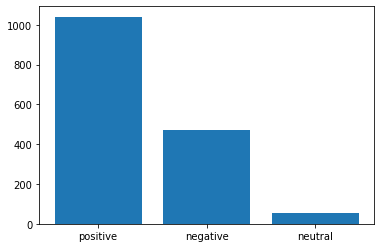

In [22]:
plt.bar(report_absolute_polarity_df['polarity'].value_counts().index, report_absolute_polarity_df['polarity'].value_counts().values)

In [23]:
report_absolute_polarity_df['polarity'].value_counts()

positive    1040
negative     473
neutral       52
Name: polarity, dtype: int64

Text(0, 0.5, 'Count')

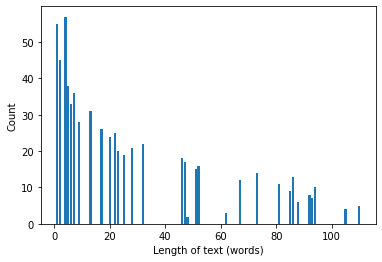

In [24]:
plt.bar(report_absolute_polarity_df['WORD_COUNT'].value_counts().values, report_absolute_polarity_df['WORD_COUNT'].value_counts().index)
plt.xlabel("Length of text (words)")
plt.ylabel("Count")

# Fine Tune Bert

In [25]:
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 2
LEARNING_RATE = 1e-05
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [26]:
bert_train_size = 0.8
bert_train_dataset=absolute_polarity_df.sample(frac=bert_train_size)
bert_test_dataset=absolute_polarity_df.drop(bert_train_dataset.index).reset_index(drop=True)
bert_train_dataset = bert_train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(absolute_polarity_df.shape))
print("TRAIN Dataset: {}".format(bert_train_dataset.shape))
print("TEST Dataset: {}".format(bert_test_dataset.shape))

bert_training_set = ModelDataset(bert_train_dataset, bert_tokenizer)
bert_testing_set = ModelDataset(bert_test_dataset, bert_tokenizer)

FULL Dataset: (1565, 2)
TRAIN Dataset: (1252, 2)
TEST Dataset: (313, 2)


In [27]:
print_split_by_labels(bert_training_set, bert_testing_set)

Train Dataset
	Positive: 836
	Neutral: 46
	Negative: 370
Test Dataset
	Positive: 204
	Neutral: 6
	Negative: 103


In [28]:
bert_train_dataloader = DataLoader(
    bert_training_set,
    sampler = RandomSampler(bert_train_dataset),
    batch_size = TRAIN_BATCH_SIZE
)

bert_validation_dataloader = DataLoader(
    bert_testing_set,
    sampler = SequentialSampler(bert_testing_set),
    batch_size = VALID_BATCH_SIZE
)

In [29]:
torch.cuda.empty_cache()
with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

4

In [30]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased').to(device)

        self.dropout = torch.nn.Dropout(0.3)

        self.out = torch.nn.Linear(768, 3)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)

        output_2 = self.dropout(output_1)
        
        output = self.out(output_2)
        
        return output

In [31]:
bert_model = BERTClass()
bert_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [32]:
loss_fn = torch.nn.BCEWithLogitsLoss()

bert_optimizer = torch.optim.Adam(params = bert_model.parameters(), lr=LEARNING_RATE)

In [33]:
def train(epoch, model, loss_fn, optimizer):
    model.train()

    for _,data in enumerate(bert_train_dataloader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        if _ % 500 == 0:
            print(f'Epoch: {epoch}, Step: {_}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [34]:
for epoch in range(EPOCHS):
    train(epoch, bert_model, loss_fn, bert_optimizer)

Epoch: 0, Step: 0, Loss:  0.7224812507629395
Epoch: 1, Step: 0, Loss:  0.09074926376342773


In [35]:
def validation(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad():
        for _, data in enumerate(bert_validation_dataloader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [36]:
outputs, targets = validation(bert_model)
outputs = np.argmax(outputs, axis=1)
targets = np.argmax(targets, axis=1)
accuracy = metrics.accuracy_score(targets, outputs)
precision_score_micro = metrics.precision_score(targets, outputs, average='micro')
precision_score_macro = metrics.precision_score(targets, outputs, average='macro')
recall_score_micro = metrics.recall_score(targets, outputs, average='micro')
recall_score_macro = metrics.recall_score(targets, outputs, average='macro')
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"Precision Score (Micro) = {precision_score_micro}")
print(f"Precision Score (Macro) = {precision_score_macro}")
print(f"Recall Score (Micro) = {recall_score_micro}")
print(f"Recall Score (Macro) = {recall_score_macro}")

Accuracy Score = 0.9009584664536742
F1 Score (Micro) = 0.9009584664536742
F1 Score (Macro) = 0.5970350404312669
Precision Score (Micro) = 0.9009584664536742
Precision Score (Macro) = 0.6010752688172043
Recall Score (Micro) = 0.9009584664536742
Recall Score (Macro) = 0.5953740719588806


D:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
torch.save(bert_model.bert, 'bert_fine_tuned.pth')

In [38]:
del bert_model

del loss_fn
del bert_optimizer

## Fine tune 10 times

In [39]:
bert_fine_tune_run = pd.DataFrame(columns=['accuracy','precision_score_micro','precision_score_macro','recall_score_micro','recall_score_macro','f1_score_micro','f1_score_macro', 'execution_time'])

In [40]:

for i in range(10):
    # clear cache cuda
    torch.cuda.empty_cache()
    with torch.no_grad():
        torch.cuda.empty_cache()
    gc.collect()

    start_time = time.time()

    print(f"Run {i + 1}/10")

    bert_train_size = 0.8
    bert_train_dataset=absolute_polarity_df.sample(frac=bert_train_size)
    bert_test_dataset=absolute_polarity_df.drop(bert_train_dataset.index).reset_index(drop=True)
    bert_train_dataset = bert_train_dataset.reset_index(drop=True)

    bert_training_set = ModelDataset(bert_train_dataset, bert_tokenizer)
    bert_testing_set = ModelDataset(bert_test_dataset, bert_tokenizer)

    print_split_by_labels(bert_training_set, bert_testing_set)

    bert_train_dataloader = DataLoader(
        bert_training_set,
        sampler = RandomSampler(bert_train_dataset),
        batch_size = TRAIN_BATCH_SIZE
    )

    bert_validation_dataloader = DataLoader(
        bert_testing_set,
        sampler = SequentialSampler(bert_testing_set),
        batch_size = VALID_BATCH_SIZE
    )

    bert_model_run = BERTClass()
    bert_model_run.to(device)

    optimizer = torch.optim.Adam(params = bert_model_run.parameters(), lr=LEARNING_RATE)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    for epoch in range(EPOCHS):
        train(epoch, bert_model_run, loss_fn, optimizer)

    outputs, targets = validation(bert_model_run)
    outputs = np.argmax(outputs, axis=1)
    targets = np.argmax(targets, axis=1)
    accuracy = metrics.accuracy_score(targets, outputs)
    precision_score_micro = metrics.precision_score(targets, outputs, average='micro')
    precision_score_macro = metrics.precision_score(targets, outputs, average='macro')
    recall_score_micro = metrics.recall_score(targets, outputs, average='micro')
    recall_score_macro = metrics.recall_score(targets, outputs, average='macro')
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    execution_time = time.time() - start_time

    bert_fine_tune_run.loc[i] = [accuracy,precision_score_micro,precision_score_macro,recall_score_micro,recall_score_macro,f1_score_micro,f1_score_macro, execution_time]

    del bert_train_dataset
    del bert_test_dataset
    del bert_training_set
    del bert_testing_set
    del bert_model_run
    del loss_fn
    del optimizer
    del outputs
    del targets

Run 1/10
Train Dataset
	Positive: 840
	Neutral: 39
	Negative: 373
Test Dataset
	Positive: 200
	Neutral: 13
	Negative: 100


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Step: 0, Loss:  0.7116765975952148
Epoch: 1, Step: 0, Loss:  0.09428238868713379


D:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 2/10
Train Dataset
	Positive: 833
	Neutral: 40
	Negative: 379
Test Dataset
	Positive: 207
	Neutral: 12
	Negative: 94


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Step: 0, Loss:  0.6823946833610535
Epoch: 1, Step: 0, Loss:  0.13427622616291046


D:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 3/10
Train Dataset
	Positive: 822
	Neutral: 43
	Negative: 387
Test Dataset
	Positive: 218
	Neutral: 9
	Negative: 86


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Step: 0, Loss:  0.6463196277618408
Epoch: 1, Step: 0, Loss:  0.13950341939926147


D:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 4/10
Train Dataset
	Positive: 833
	Neutral: 40
	Negative: 379
Test Dataset
	Positive: 207
	Neutral: 12
	Negative: 94


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Step: 0, Loss:  0.75067538022995
Epoch: 1, Step: 0, Loss:  0.1553804576396942


D:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 5/10
Train Dataset
	Positive: 825
	Neutral: 42
	Negative: 385
Test Dataset
	Positive: 215
	Neutral: 10
	Negative: 88


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Step: 0, Loss:  0.7162754535675049
Epoch: 1, Step: 0, Loss:  0.08361220359802246


D:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 6/10
Train Dataset
	Positive: 843
	Neutral: 41
	Negative: 368
Test Dataset
	Positive: 197
	Neutral: 11
	Negative: 105


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Step: 0, Loss:  0.8092023730278015
Epoch: 1, Step: 0, Loss:  0.09687098115682602


D:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 7/10
Train Dataset
	Positive: 835
	Neutral: 38
	Negative: 379
Test Dataset
	Positive: 205
	Neutral: 14
	Negative: 94


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Step: 0, Loss:  0.8028361797332764
Epoch: 1, Step: 0, Loss:  0.10998150706291199


D:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 8/10
Train Dataset
	Positive: 834
	Neutral: 49
	Negative: 369
Test Dataset
	Positive: 206
	Neutral: 3
	Negative: 104


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Step: 0, Loss:  0.6743930578231812
Epoch: 1, Step: 0, Loss:  0.382513165473938
Run 9/10
Train Dataset
	Positive: 823
	Neutral: 40
	Negative: 389
Test Dataset
	Positive: 217
	Neutral: 12
	Negative: 84


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Step: 0, Loss:  0.7102643251419067
Epoch: 1, Step: 0, Loss:  0.5295178890228271


D:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run 10/10
Train Dataset
	Positive: 834
	Neutral: 37
	Negative: 381
Test Dataset
	Positive: 206
	Neutral: 15
	Negative: 92


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Step: 0, Loss:  0.7807523608207703
Epoch: 1, Step: 0, Loss:  0.26417455077171326


D:\Apps\Anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
bert_fine_tune_run

,accuracy,precision_score_micro,precision_score_macro,recall_score_micro,recall_score_macro,f1_score_micro,f1_score_macro,execution_time
0,0.907348,0.907348,0.596835,0.907348,0.630000,0.907348,0.612722,186.395960
1,0.907348,0.907348,0.594757,0.907348,0.621869,0.907348,0.607969,185.522013
2,0.872204,0.872204,0.605499,0.872204,0.548859,0.872204,0.565108,184.061373
3,0.888179,0.888179,0.577564,0.888179,0.610272,0.888179,0.593054,184.818004
4,0.881789,0.881789,0.569228,0.881789,0.600194,0.881789,0.583756,185.216141
5,0.865815,0.865815,0.576437,0.865815,0.587527,0.865815,0.581472,184.536646
6,0.884984,0.884984,0.576391,0.884984,0.623214,0.884984,0.597042,185.456679
7,0.926518,0.926518,0.627030,0.926518,0.605738,0.926518,0.614080,184.582411
8,0.859425,0.859425,0.557392,0.859425,0.573733,0.859425,0.565343,184.570498
9,0.881789,0.881789,0.570969,0.881789,0.621043,0.881789,0.592665,185.581295


In [42]:
bert_fine_tune_run.to_csv("bert_fine_tune_10runs.csv")